In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import wntr
from wntr.msx.elements import InitialQuality
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')
wn.options.quality.parameter = 'NONE'

In [16]:
wn.add_msx_model()
wn.msx.options.area_units = 'FT2'
wn.msx.options.rate_units = 'DAY'
wn.msx.options.timestep = 300
wn.msx.add_species('T1','bulk',units='MG', note='Source 1 Tracer')
wn.msx.add_species('CL2','bulk', units='MG', note='Free Chlorine')
k1 = wn.msx.add_constant('k1', 1.3)
k2 = wn.msx.add_constant('k2', 17.7)
wn.msx.add_reaction('T1', 'pipe', 'rate', '0')
wn.msx.add_reaction('CL2', 'pipe', 'rate', '-(k1*T1 + k2*(1-T1))*CL2')
wn.msx.add_reaction('T1', 'tank', 'rate', '0')
wn.msx.add_reaction('CL2', 'tank', 'rate', '-(k1*T1 + k2*(1-T1))*CL2')

Reaction(species_name='CL2', expression_type=<ExpressionType.RATE: 2>, expression='-(k1*T1 + k2*(1-T1))*CL2')

In [17]:
wn.msx.network_data.initial_quality['T1'] = InitialQuality(node_values={'River': 1.0})
wn.msx.network_data.initial_quality['CL2'] = InitialQuality(node_values={'River':1.2, 'Lake':1.2})

In [18]:
sim = wntr.sim.EpanetSimulator(wn)
res = sim.run_sim()

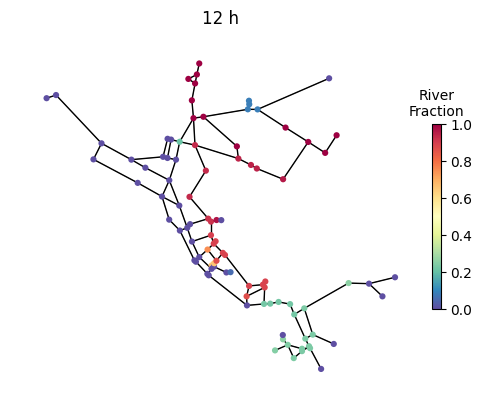

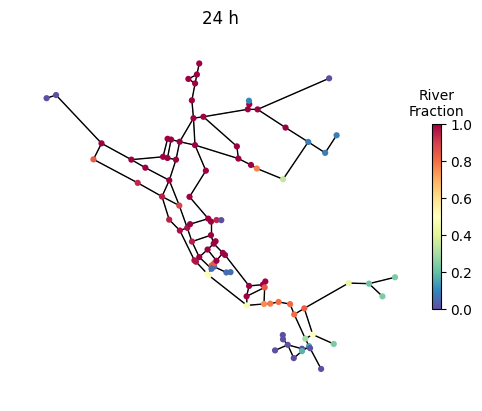

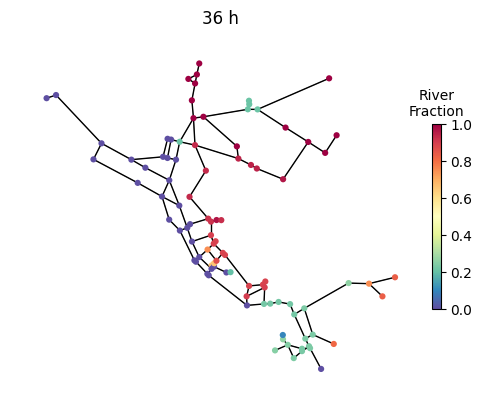

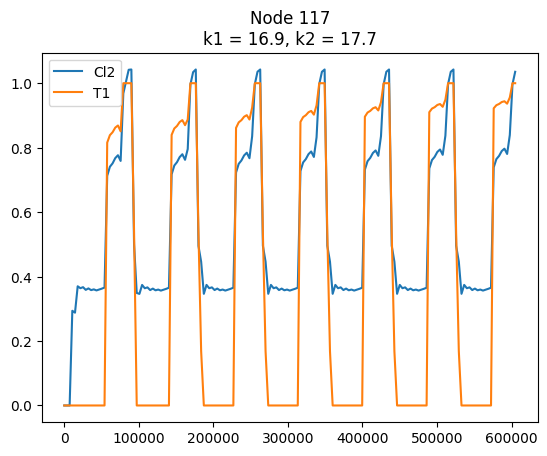

In [25]:
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*12,:], 
    title='12 h', node_colorbar_label='River\nFraction',
)
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*24,:], 
    title='24 h', node_colorbar_label='River\nFraction',
)
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*36,:], 
    title='36 h', node_colorbar_label='River\nFraction',
)
query = '117'  # '191', '269', '117'
res.node['CL2'][query].plot()
res.node['T1'][query].plot()
plt.title('Node {}\nk1 = {:.1f}, k2 = {:.1f}'.format(query, k1.value, k2.value))
_=plt.legend(['Cl2', 'T1'])

In [22]:
d_k1 = dict()
for i in range(7):
    newk = 1.3 + (2*i*1.3)
    k1.value = newk
    resk = sim.run_sim()
    d_k1[newk] = resk

Text(0.5, 1.0, 'Cl2 at node 117')

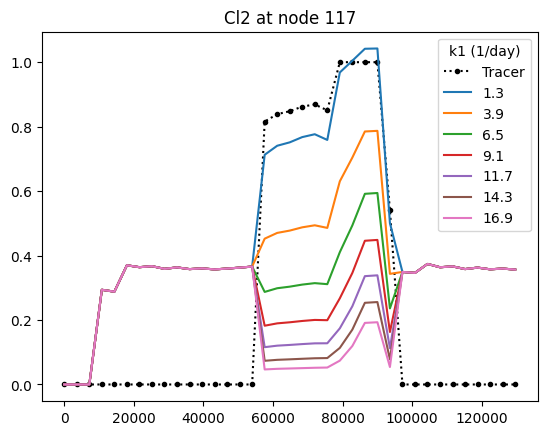

In [24]:
res.node["T1"].loc[0:3600*36, query].plot(style='k.:')
for newk, resk in d_k1.items():
    resk.node["CL2"].loc[0:3600*36, query].plot()
plt.legend(['Tracer', *["{:.1f}".format(k) for k in d_k1.keys()]], title="k1 (1/day)")
plt.title("Cl2 at node {}".format(query))